# Кластеризация: $k$-means и DBSCAN

В этом ноутбуке мы разберём задачу **кластеризации** (unsupervised learning) и два классических метода:

- **$k$-means** — метод кластеризации на основе минимизации суммы квадратов расстояний до центров кластеров;
- **DBSCAN** — плотностный метод кластеризации, который умеет выделять кластеры произвольной формы и шумовые точки.

План ноутбука:

1. Что такое кластеризация и зачем она нужна.
2. Синтетические данные для экспериментов.
3. Метод $k$-means: постановка задачи и алгоритм.
4. $k$-means на простом примере.
5. Выбор числа кластеров: метод локтя и коэффициент силуэта.
6. Метрики качества кластеризации (external и internal).
7. Ограничения и особенности $k$-means.
8. DBSCAN: плотностная кластеризация, параметры $\varepsilon$ и `min_samples`.
9. DBSCAN на примерах и сравнение с $k$-means.
10. Выбор параметров DBSCAN (кривые расстояний).
11. Плюсы и минусы $k$-means и DBSCAN, практические рекомендации.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

np.random.seed(42)

In [2]:
def plot_clusters(X, labels, title="Кластеризация", centers=None):
    """Простой помощник для визуализации кластеров в 2D."""
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=labels)
    plt.title(title)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], marker="x", s=200)
    plt.show()

## 1. Что такое кластеризация и зачем она нужна

**Кластеризация** — это задача **неподконтрольного обучения** (unsupervised learning), в которой у нас есть только объекты $x_i$, но **нет правильных меток** $y_i$.

Цель кластеризации — разбить объекты на группы (кластеры) так, чтобы:

- объекты внутри одного кластера были **похожи** друг на друга,
- объекты из разных кластеров были **как можно более различны**.

Формально мы хотим построить отображение

$$
x_i \mapsto c_i,
$$

где $c_i \in \{1, \dots, K\}$ — номер кластера (метка кластера), а $K$ — число кластеров (может быть известно заранее или нет, в зависимости от метода).

### Примеры практических задач кластеризации

1. **Сегментация пользователей** в маркетинге.
   - Есть база клиентов с признаками: возраст, доход, частота покупок, средний чек и т.п.
   - Задача: разбить клиентов на сегменты, чтобы по ним потом настраивать разные стратегии.

2. **Кластеризация документов или новостей.**
   - Векторизуем тексты (TF-IDF, эмбеддинги).
   - Кластеризация помогает:
     - выделять темы,
     - группировать похожие статьи,
     - упрощать поиск и рекомендацию.

3. **Кластеризация изображений.**
   - Есть эмбеддинги картинок (например, из сверточной сети).
   - Кластеризация может сгруппировать визуально похожие изображения (одежда, объекты и т.п.).

4. **Выделение аномалий.**
   - Кластеры описывают типичные объекты.
   - Объекты, которые не попадают ни в один кластер, могут быть аномальными (мошенничество, сбои).

5. **Предварительный анализ данных (exploratory data analysis).**
   - Кластеризация помогает понять структуру данных:
     - есть ли естественные группы,
     - какие признаки важны,
     - есть ли подозрительные группы или выбросы.

Важно понимать, что в кластеризации **нет правильного ответа** в том же смысле, как в классификации. Мы оцениваем качество по косвенным критериям (internal метрики) или, если есть метки, по external метрикам.


## 2. Синтетические данные для экспериментов

Для иллюстрации методов кластеризации удобно использовать синтетические двумерные датасеты, которые легко визуализировать.

Мы будем пользоваться несколькими типами данных:

- **Компактные кластеры (blobs)** — хорошо подходят для $k$-means.
- **Кластеры произвольной формы (например, `make_moons`)** — полезны для демонстрации преимуществ DBSCAN.
- **Кластеры с разной плотностью** — показывают ограничения разных методов.


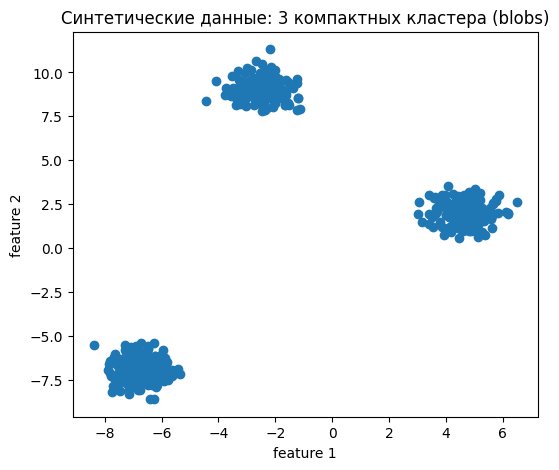

In [3]:
# 2.1. Простой датасет с тремя компактными кластерами
X_blobs, y_blobs_true = make_blobs(
    n_samples=600,
    centers=3,
    cluster_std=0.60,
    random_state=42
)

plt.figure(figsize=(6, 5))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1])
plt.title("Синтетические данные: 3 компактных кластера (blobs)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

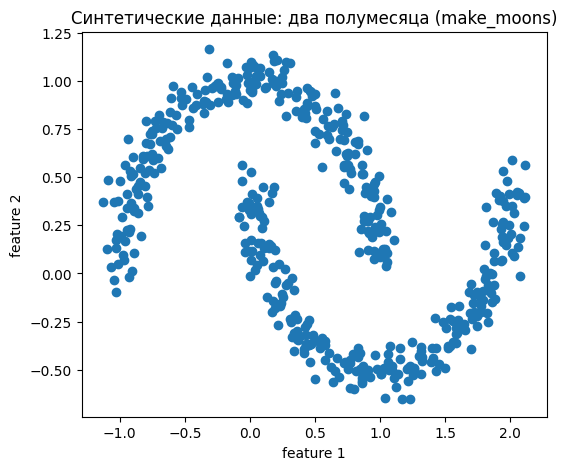

In [4]:
# 2.2. Датасет с кластерами произвольной формы: две "полумесяца"
X_moons, y_moons_true = make_moons(
    n_samples=500,
    noise=0.07,
    random_state=42
)

plt.figure(figsize=(6, 5))
plt.scatter(X_moons[:, 0], X_moons[:, 1])
plt.title("Синтетические данные: два полумесяца (make_moons)")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

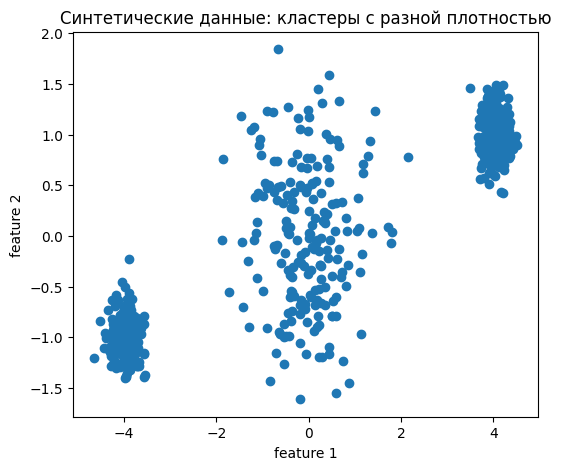

In [5]:
# 2.3. Датасет с разной плотностью кластеров
X_varied, y_varied_true = make_blobs(
    n_samples=600,
    centers=[[-4, -1], [0, 0], [4, 1]],
    cluster_std=[0.2, 0.7, 0.2],
    random_state=42
)

plt.figure(figsize=(6, 5))
plt.scatter(X_varied[:, 0], X_varied[:, 1])
plt.title("Синтетические данные: кластеры с разной плотностью")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

## 3. Метод $k$-means: постановка задачи и алгоритм

Пусть у нас есть выборка из $n$ объектов $x_1, \dots, x_n$, каждый из которых — вектор признаков из $\mathbb{R}^d$. Мы хотим разбить эти объекты на $K$ кластеров.

В $k$-means мы ищем:

- разбиение объектов по кластерам,
- центры кластеров $\mu_1, \dots, \mu_K$, где
  $$
  \mu_k \in \mathbb{R}^d,
  $$

таким образом, чтобы **минимизировать суммарную сумму квадратов расстояний** от объектов до центров своих кластеров.

Обозначим через $C_k$ множество индексов объектов, попавших в кластер $k$. Целевая функция $k$-means:

$$
J = \sum_{k=1}^K \sum_{i \in C_k} \lVert x_i - \mu_k \rVert^2.
$$

Мы хотим найти разбиение $\{C_k\}$ и центры $\{\mu_k\}$, минимизирующие $J$.


### 3.1. Алгоритм $k$-means

Классический алгоритм $k$-means — это итеративный процесс, который чередует два шага.

1. **Инициализация.**
   - Выбираем начальные центры $\mu_1, \dots, \mu_K$ (например, случайные объекты из выборки или метод $k$-means++).

2. **Шаг назначения (assignment step).**
   - Для каждого объекта $x_i$ выбираем ближайший по евклидову расстоянию центр:
     $$
     c_i = \arg\min_{k \in \{1, \dots, K\}} \lVert x_i - \mu_k \rVert^2.
     $$
   - Таким образом, формируем кластеры $C_k = \{ i : c_i = k \}$.

3. **Шаг пересчёта центров (update step).**
   - Для каждого кластера $k$ пересчитываем центр как среднее по всем объектам, попавшим в кластер:
     $$
     \mu_k = \frac{1}{|C_k|} \sum_{i \in C_k} x_i.
     $$

4. Повторяем шаги 2–3 до сходимости:
   - либо пока назначения $c_i$ перестают меняться,
   - либо пока изменение целевой функции $J$ становится меньше порога,
   - либо пока не достигнем максимального числа итераций.

Этот алгоритм всегда **снижает** значение $J$ на каждой итерации и сходится к **локальному минимуму**, но не обязательно к глобальному.


### 3.2. Инерция и внутренняя дисперсия кластеров

В `scikit-learn` у объекта `KMeans` есть атрибут `inertia_`. Это и есть значение целевой функции $J$ после обучения:

$$
\text{inertia} = \sum_{k=1}^K \sum_{i \in C_k} \lVert x_i - \mu_k \rVert^2.
$$

Инерция характеризует **насколько компактны** кластеры:

- чем меньше инерция, тем ближе объекты к своим центрам;
- при фиксированном $K$ меньшая инерция обычно лучше (но не всегда, возможны вырождения).

При увеличении $K$ инерция **всегда не возрастает**, потому что при большем числе кластеров мы можем только улучшить (или оставить прежним) оптимизацию $J$. Поэтому инерцию используют для выбора $K$ (метод локтя).


### 3.3. Предположения и ограничения $k$-means

$k$-means хорошо работает, когда соблюдаются следующие предположения:

- кластеры имеют примерно **сферическую форму** в пространстве признаков;
- кластеры имеют **сравнимые размеры и дисперсии**;
- метрика похожести — евклидово расстояние или близкая к нему;
- данные не содержат сильных выбросов, которые могли бы тянуть центры.

Ограничения:

- метод чувствителен к **масштабу признаков** (поэтому важно масштабировать данные);
- число кластеров $K$ нужно **задавать заранее**;
- результат зависит от **инициализации** центров (можно частично исправить $k$-means++ и несколькими запусками);
- плохо работает на **кластерах сложной формы** (полумесяцы, кольца и т.п.).


## 4. $k$-means на простом примере

Применим $k$-means к датасету с тремя компактными кластерами `X_blobs`.

Сначала обучим модель при правильном числе кластеров $K = 3$.


Инерция при K = 3: 417.9249778791968


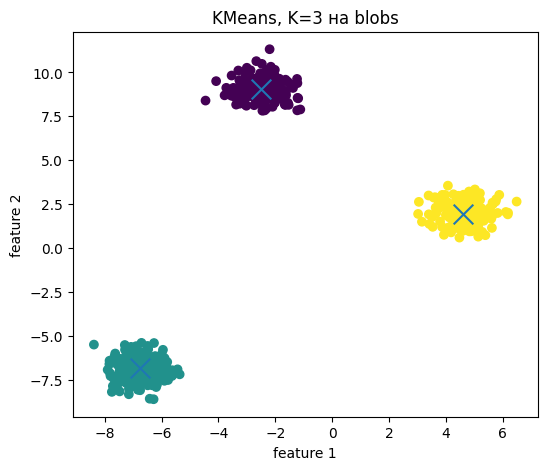

In [6]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_3.fit(X_blobs)

labels_3 = kmeans_3.labels_
centers_3 = kmeans_3.cluster_centers_
inertia_3 = kmeans_3.inertia_

print("Инерция при K = 3:", inertia_3)

plot_clusters(X_blobs, labels_3, title="KMeans, K=3 на blobs", centers=centers_3)

Теперь попробуем неверное число кластеров, например $K = 2$ и $K = 4$, и посмотрим, как меняются инерция и картинка.


K = 2, inertia = 10500.54


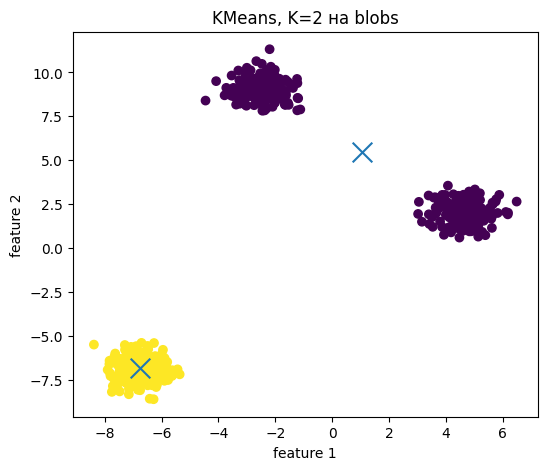

K = 4, inertia = 365.41


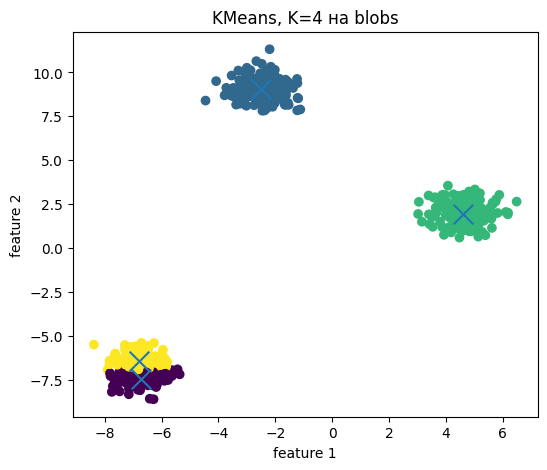

In [7]:
for K in [2, 4]:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(X_blobs)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    print(f"K = {K}, inertia = {inertia:.2f}")
    plot_clusters(X_blobs, labels, title=f"KMeans, K={K} на blobs", centers=centers)

Инерция уменьшается с ростом $K$, но это не значит, что большее количество кластеров всегда лучше. Нужно искать баланс между компактностью кластеров и сложностью модели (числом кластеров).


Простая ручная реализация:

In [22]:
# pip install imageio

import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os

np.random.seed(42)

def kmeans_manual_gif(X, K=3, n_iter=10, gif_path="kmeans_steps.gif"):
    # 1. Инициализация центров из случайных точек
    centers = X[np.random.choice(len(X), K, replace=False)]

    frames = []
    tmp_dir = "_kmeans_frames"
    os.makedirs(tmp_dir, exist_ok=True)

    for it in range(n_iter):
        # --- assignment step ---
        # матрица расстояний: (n_samples, K)
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
        labels = dists.argmin(axis=1)

        # --- визуализация ---
        fig, ax = plt.subplots(figsize=(6, 5))
        scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, s=40)
        ax.scatter(centers[:, 0], centers[:, 1], marker="x", s=200)
        ax.set_title(f"k-means, итерация {it}")
        ax.set_xlabel("feature 1")
        ax.set_ylabel("feature 2")

        frame_path = os.path.join(tmp_dir, f"frame_{it:02d}.png")
        plt.savefig(frame_path, bbox_inches="tight")
        plt.close(fig)

        frames.append(imageio.imread(frame_path))

        # --- update step ---
        new_centers = []
        for k in range(K):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centers.append(cluster_points.mean(axis=0))
            else:
                # если кластер пустой — оставляем центр как был
                new_centers.append(centers[k])
        centers = np.vstack(new_centers)

    imageio.mimsave(gif_path, frames, duration=0.7)
    print("GIF сохранён в", gif_path)

# Пример: возьмём blobs
from sklearn.datasets import make_blobs
X_blobs, _ = make_blobs(n_samples=500, centers=10, cluster_std=0.7, random_state=42)

kmeans_manual_gif(X_blobs, K=10, n_iter=20, gif_path="kmeans_blobs.gif")

GIF сохранён в kmeans_blobs.gif


Проверка sklearn на датасете с полумесяцами:

K = 2, inertia = 204.75


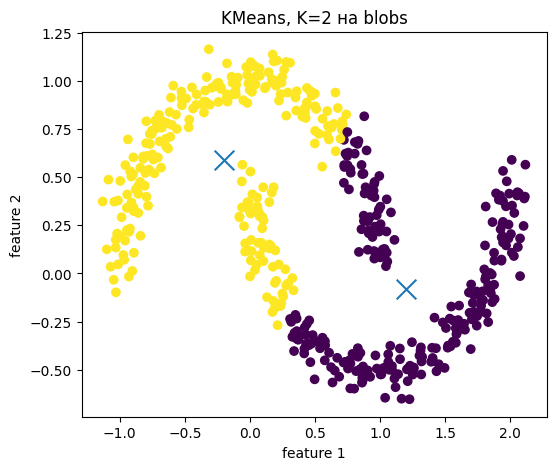

K = 4, inertia = 88.55


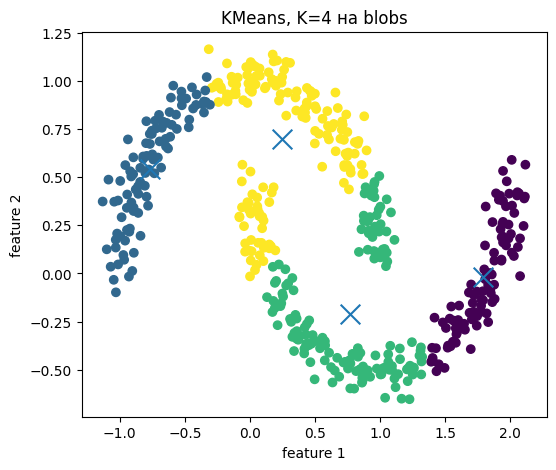

In [23]:
for K in [2, 4]:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(X_moons)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    inertia = kmeans.inertia_
    print(f"K = {K}, inertia = {inertia:.2f}")
    plot_clusters(X_moons, labels, title=f"KMeans, K={K} на blobs", centers=centers)

## 5. Выбор числа кластеров: метод локтя и коэффициент силуэта

Поскольку в $k$-means число кластеров $K$ задаётся вручную, возникает вопрос: **как выбрать разумное $K$?**

Два популярных подхода:

1. **Метод локтя (elbow method)** — анализируем зависимость инерции от $K$.
2. **Коэффициент силуэта (silhouette score)** — анализируем, насколько хорошо объекты отделены от других кластеров и близки к своему кластеру.


### 5.1. Метод локтя

Идея метода локтя:

- обучаем $k$-means для разных значений $K$ (например, от $1$ до $10$);
- строим график зависимости инерции от $K$;
- ищем точку, где снижение инерции замедляется ("локоть").

Формально эта точка не всегда определяется однозначно, но часто визуально видно разумный выбор.


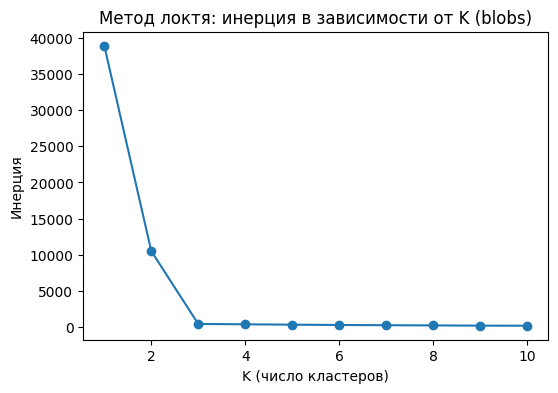

In [8]:
Ks = range(1, 11)
inertias = []

for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    kmeans.fit(X_blobs)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(list(Ks), inertias, marker="o")
plt.title("Метод локтя: инерция в зависимости от K (blobs)")
plt.xlabel("K (число кластеров)")
plt.ylabel("Инерция")
plt.show()

На графике обычно видно, что после некоторого $K$ снижение инерции становится менее существенным. В нашем примере разумным выбором является $K = 3$ (виден "локоть").


### 5.2. Коэффициент силуэта

**Силуэт** измеряет, насколько хорошо каждый объект расположен внутри своего кластера по сравнению с соседними кластерами.

Для одного объекта $i$:

- $a(i)$ — среднее расстояние до всех объектов внутри его кластера;
- $b(i)$ — минимальное среднее расстояние до объектов из какого-либо другого кластера.

Тогда коэффициент силуэта для объекта $i$:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}.
$$

Свойства:

- $s(i)$ лежит в диапазоне $[-1, 1]$;
- $s(i) \approx 1$ — объект хорошо вписан в свой кластер и далеко от других;
- $s(i) \approx 0$ — объект лежит на границе между кластерами;
- $s(i) < 0$ — объект, возможно, отнесён к "неправильному" кластеру.

Средний силуэт по выборке:

$$
S = \frac{1}{n} \sum_{i=1}^n s(i)
$$

можно использовать как метрику качества кластеризации при разном $K$.


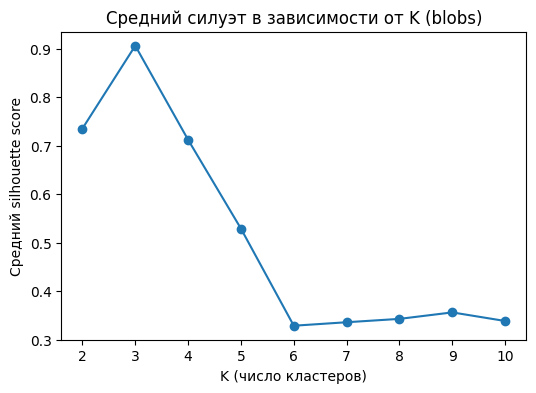

In [9]:
Ks = range(2, 11)
silhouettes = []

for K in Ks:
    kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_blobs)
    score = silhouette_score(X_blobs, labels)
    silhouettes.append(score)

plt.figure(figsize=(6, 4))
plt.plot(list(Ks), silhouettes, marker="o")
plt.title("Средний силуэт в зависимости от K (blobs)")
plt.xlabel("K (число кластеров)")
plt.ylabel("Средний silhouette score")
plt.show()

В хорошем случае значение силуэта достигает максимума примерно при "правильном" $K$.

Сочетая метод локтя (по инерции) и анализ силуэта, можно выбрать разумное число кластеров.


## 6. Метрики качества кластеризации

Оценка кластеризации — нетривиальная задача, потому что:

- часто у нас **нет истинных меток**;
- мы оптимизируем некоторые внутренние критерии (например, инерцию), которые могут не совпадать с реальными целями.

Метрики условно делят на два типа:

1. **External метрики** — используются, когда у нас есть истинные метки $y_i$ (например, в синтетических примерах или при оценке алгоритмов).
2. **Internal метрики** — измеряют качество кластеризации, используя только сами данные и кластерные метки.


### 6.1. External метрики (при наличии истинных меток)

Если мы знаем истинные метки $y_i$ (например, в синтетике), можем использовать:

1. **Adjusted Rand Index (ARI)** — скор, основанный на парных согласиях и несогласиях:

   - сравнивает, как часто пары объектов находятся в одном и том же (или разных) кластерах в предсказании и в истине;
   - $\text{ARI} = 1$ — полное совпадение;
   - $\text{ARI} \approx 0$ — случайная кластеризация;
   - возможно отрицательное значение при очень плохом совпадении.

2. **Normalized Mutual Information (NMI)** — нормированная взаимная информация между истинными метками и кластерными метками:

   - измеряет, сколько информации о истинных метках содержат кластерные метки;
   - лежит в диапазоне $[0, 1]$;
   - $\text{NMI} = 1$ — полное совпадение.

В `scikit-learn`:
- `adjusted_rand_score(y_true, y_pred)`,
- `normalized_mutual_info_score(y_true, y_pred)`.


### 6.2. Internal метрики (без истинных меток)

Когда истинных меток нет, используют внутренние метрики:

1. **Silhouette score** — уже рассмотрели.
2. **Calinski-Harabasz index**:
   - отношение межкластерной дисперсии к внутрикластерной;
   - чем больше, тем лучше.

3. **Davies-Bouldin index**:
   - измеряет среднее сходство кластеров (с учётом расстояний между центрами и разброса внутри кластеров);
   - чем **меньше**, тем лучше.

В `scikit-learn`:
- `silhouette_score(X, labels)`,
- `calinski_harabasz_score(X, labels)`,
- `davies_bouldin_score(X, labels)`.


In [10]:
def evaluate_clustering(X, labels, true_labels=None):
    print("Silhouette score:", silhouette_score(X, labels))
    print("Calinski-Harabasz index:", calinski_harabasz_score(X, labels))
    print("Davies-Bouldin index:", davies_bouldin_score(X, labels))
    if true_labels is not None:
        print("Adjusted Rand Index:", adjusted_rand_score(true_labels, labels))
        print("Normalized Mutual Information:", normalized_mutual_info_score(true_labels, labels))

Пример: оценим $k$-means на датасете `X_blobs` с $K = 3$.


In [11]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(X_blobs)

evaluate_clustering(X_blobs, labels_3, true_labels=y_blobs_true)

Silhouette score: 0.9060489226554301
Calinski-Harabasz index: 27499.769474487926
Davies-Bouldin index: 0.13276449705589263
Adjusted Rand Index: 1.0
Normalized Mutual Information: 1.0


## 7. Ограничения $k$-means

Метод $k$-means прост и эффективен, но имеет важные ограничения:

1. **Форма кластеров.**
   - Предполагается, что кластеры в пространстве признаков примерно сферические и разделимы гиперплоскостями (в евклидовой метрике).
   - Для кластеров сложной формы ("полумесяцы", кольца, вытянутые или изогнутые кластеры) $k$-means даёт неудовлетворительные результаты.

2. **Разная плотность и размер кластеров.**
   - Если один кластер плотный и маленький, а другой разреженный и большой, $k$-means может разбить один большой на несколько и слить маленький с частью большого.

3. **Чувствительность к масштабированию признаков.**
   - Если признаки имеют разный масштаб (например, одни в диапазоне $[0, 1]$, другие — тысячи), дистанции будут доминироваться признаками с большим масштабом.
   - Обычно перед $k$-means применяют масштабирование (например, `StandardScaler`).

4. **Выбросы.**
   - Выбросы могут сильно сдвигать центры кластеров, потому что в целевой функции используется сумма квадратов расстояний.

5. **Необходимость задавать $K$ заранее.**
   - Число кластеров неизвестно и требует дополнительного анализа (локоть, силуэт, предметная область).


## 8. DBSCAN: плотностная кластеризация

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** — метод кластеризации на основе плотности. Его ключевые идеи:

- кластеры определяются как области повышенной плотности точек, отделённые областями низкой плотности;
- метод умеет находить кластеры произвольной формы (не только сферические);
- DBSCAN может выделять шумовые точки (outliers), которые не принадлежат ни одному кластеру.

DBSCAN имеет два основных гиперпараметра:

1. $\varepsilon$ (`eps`) — радиус окрестности для точки;
2. `min_samples` — минимальное число точек в окрестности радиуса $\varepsilon$, чтобы считать точку "ядром" кластера.


### 8.1. Типы точек в DBSCAN

DBSCAN разделяет точки на три типа:

1. **Ядровая (core point).**
   - Точка $p$ ядровая, если в её $\varepsilon$-окрестности (включая её саму) содержится как минимум `min_samples` точек.
   - Формально, если
     $$
     |\{ q : \lVert q - p \rVert \le \varepsilon \}| \ge \text{min\_samples}.
     $$

2. **Пограничная (border point).**
   - Точка $p$ не является ядром, но лежит в $\varepsilon$-окрестности некоторой ядровой точки.

3. **Шумовая (noise point).**
   - Точка, которая не является ни ядром, ни пограничной — то есть не входит ни в одну плотную область.

Кластеры строятся как связные компоненты по отношению **достижимости по плотности** (density reachability) между ядровыми и пограничными точками.


### 8.2. Алгоритм DBSCAN (упрощённо)

1. Для каждой точки считаем количество соседей в радиусе $\varepsilon$.
2. Отмечаем ядровые точки (те, у которых соседей не меньше `min_samples`).
3. Строим кластеры:
   - выбираем ещё не посещённую ядровую точку, создаём новый кластер;
   - добавляем в кластер все точки, которые достижимы по плотности (через последовательность соседей в радиусе $\varepsilon$);
   - помечаем их как принадлежащие этому кластеру.
4. Все точки, не попавшие ни в один кластер, помечаются как шум (кластер с меткой $-1$ в `scikit-learn`).

Особенности:

- число кластеров DBSCAN **не задаётся заранее** — оно определяется автоматически из структуры данных;
- метод устойчив к выбросам, так как отдельные точки могут остаться шумом и не искажать кластеры.


## 9. DBSCAN на примерах и сравнение с $k$-means

Рассмотрим датасет `X_moons` (два полумесяца), который является классическим примером сложной формы кластеров.


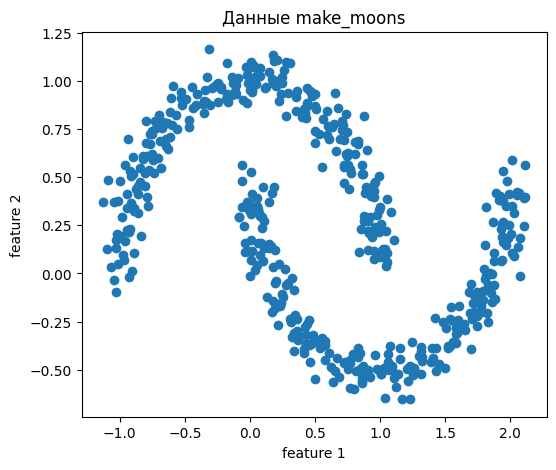

In [12]:
plt.figure(figsize=(6, 5))
plt.scatter(X_moons[:, 0], X_moons[:, 1])
plt.title("Данные make_moons")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

Попробуем сначала применить $k$-means с $K = 2$ к этим данным.


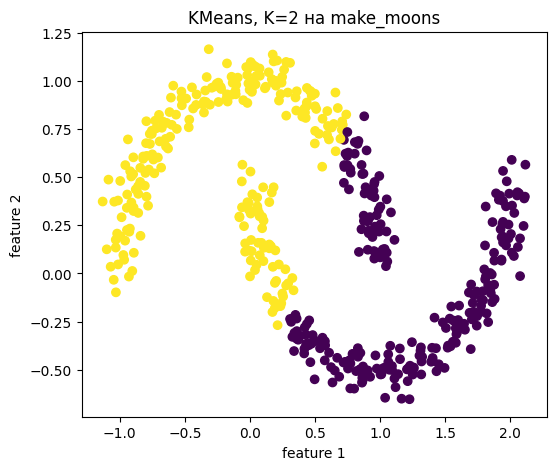

In [13]:
kmeans_moons = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_kmeans_moons = kmeans_moons.fit_predict(X_moons)

plot_clusters(X_moons, labels_kmeans_moons, title="KMeans, K=2 на make_moons")

Видно, что $k$-means пытается делить данные "по прямой", не учитывая форму полумесяцев. Кластеры получаются неудовлетворительными.

Теперь применим DBSCAN.

Важно: DBSCAN чувствителен к масштабированию, поэтому обычно перед ним делают `StandardScaler` или другую нормализацию.


Уникальные кластеры DBSCAN: [0 1]


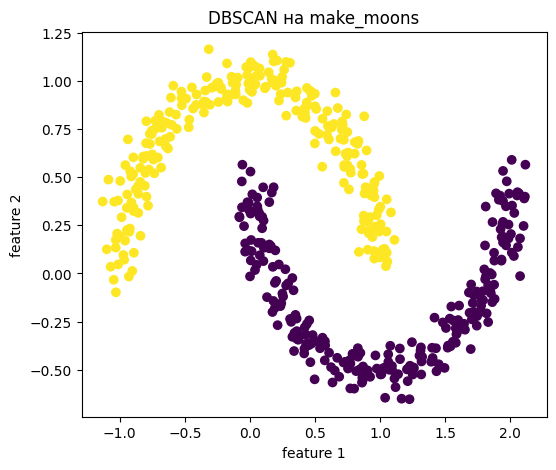

In [14]:
scaler_moons = StandardScaler()
X_moons_scaled = scaler_moons.fit_transform(X_moons)

dbscan_moons = DBSCAN(eps=0.3, min_samples=5)
labels_dbscan_moons = dbscan_moons.fit_predict(X_moons_scaled)

print("Уникальные кластеры DBSCAN:", np.unique(labels_dbscan_moons))

plot_clusters(X_moons, labels_dbscan_moons, title="DBSCAN на make_moons")

Здесь:

- две основные группы точек сформировали кластеры;
- при удачном выборе `eps` и `min_samples` DBSCAN выделяет полумесяца как два отдельных кластера;
- возможны точки с меткой $-1$ — это шум.

Сравним некоторые метрики (поскольку у нас есть истинные метки `y_moons_true`).

In [15]:
print("KMeans на make_moons:")
evaluate_clustering(X_moons, labels_kmeans_moons, true_labels=y_moons_true)

print("\nDBSCAN на make_moons:")
evaluate_clustering(X_moons, labels_dbscan_moons, true_labels=y_moons_true)

KMeans на make_moons:
Silhouette score: 0.4868823178121248
Calinski-Harabasz index: 730.1137642872457
Davies-Bouldin index: 0.7847293626977362
Adjusted Rand Index: 0.2606624564610498
Normalized Mutual Information: 0.19839188151428427

DBSCAN на make_moons:
Silhouette score: 0.33191077569603555
Calinski-Harabasz index: 331.33776970980426
Davies-Bouldin index: 1.152502522692789
Adjusted Rand Index: 1.0
Normalized Mutual Information: 1.0


Рассмотрим теперь датасет с разной плотностью кластеров `X_varied`. Такие данные сложны для методов, предполагающих равномерную плотность.


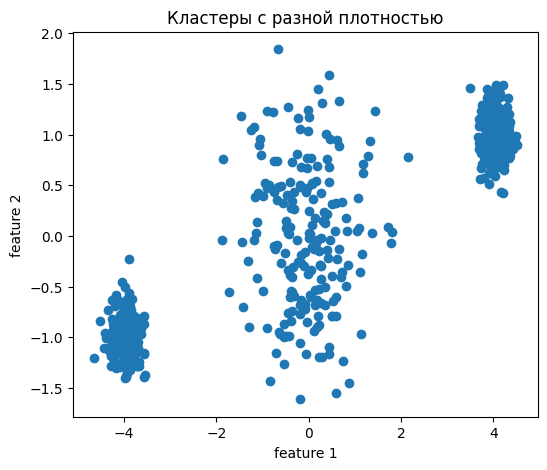

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(X_varied[:, 0], X_varied[:, 1])
plt.title("Кластеры с разной плотностью")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

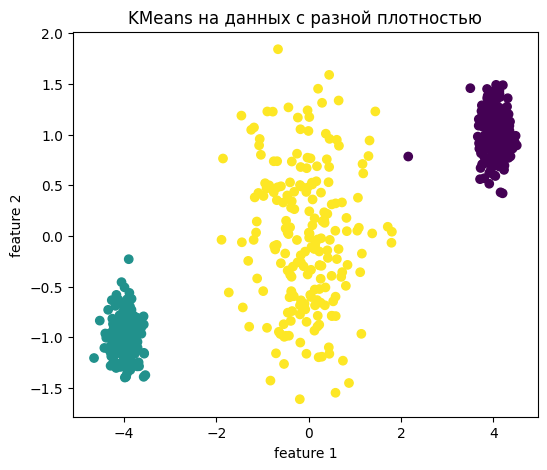

In [17]:
# KMeans на данных с разной плотностью
kmeans_varied = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans_varied = kmeans_varied.fit_predict(X_varied)

plot_clusters(X_varied, labels_kmeans_varied, title="KMeans на данных с разной плотностью")

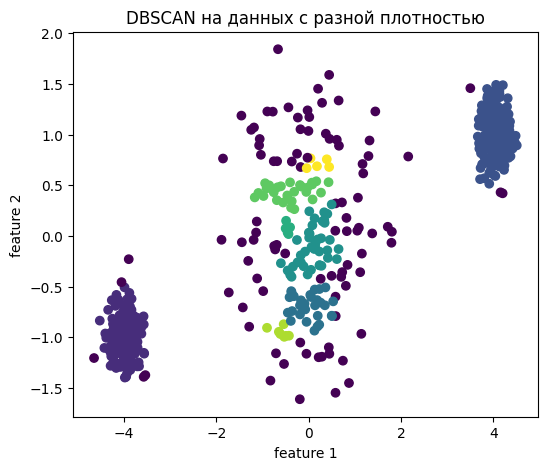

In [25]:
# DBSCAN на тех же данных (после масштабирования)
scaler_varied = StandardScaler()
X_varied_scaled = scaler_varied.fit_transform(X_varied)

dbscan_varied = DBSCAN(eps=0.1, min_samples=5)
labels_dbscan_varied = dbscan_varied.fit_predict(X_varied_scaled)

plot_clusters(X_varied, labels_dbscan_varied, title="DBSCAN на данных с разной плотностью")

Здесь видно, что:

- $k$-means делит данные на три кластера, но может игнорировать разницу в плотности;
- DBSCAN при фиксированном `eps` может, например, слить разреженный крупный кластер с шумом или не выделить его вообще.

DBSCAN чувствителен к выбору `eps`, особенно в случае кластеров с разной плотностью.


## 10. Выбор параметров DBSCAN: $\varepsilon$ и `min_samples`

Практический подход к выбору $\varepsilon$ для DBSCAN — анализировать расстояния до $k$-го ближайшего соседа (обычно $k = \text{min\_samples}$).

Алгоритм:

1. Для каждой точки считаем расстояние до её $k$-го ближайшего соседа.
2. Сортируем эти расстояния по возрастанию.
3. Строим график. Ищем "колено" (elbow) — точку, где расстояния начинают существенно расти.
4. Значение $\varepsilon$ выбирают примерно в области этого "колена".

Покажем пример для `X_moons_scaled`.


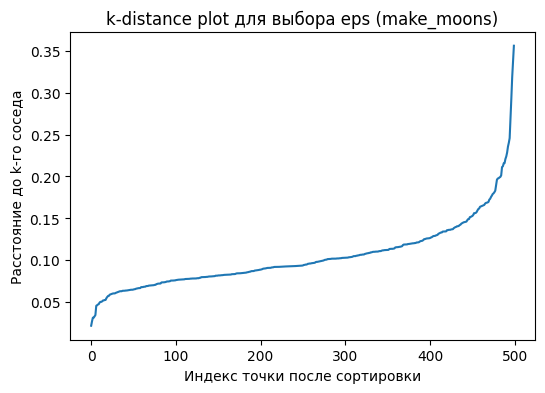

In [19]:
k = 5  # min_samples
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(X_moons_scaled)
distances, indices = neighbors.kneighbors(X_moons_scaled)

# Расстояния до k-го соседа для каждой точки
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(k_distances)
plt.title("k-distance plot для выбора eps (make_moons)")
plt.xlabel("Индекс точки после сортировки")
plt.ylabel("Расстояние до k-го соседа")
plt.show()

На таком графике обычно видно участок, где расстояния резко начинают расти: это и есть потенциальная область для выбора $\varepsilon$.

Выбор `min_samples`:

- часто берут значение чуть больше размерности пространства (например, $d + 1$);
- в двумерных примерах часто используют значения 4–5;
- увеличение `min_samples` делает критерий плотности более строгим (нужен более плотный кластер).

На практике выбор $\varepsilon$ и `min_samples` требует экспериментов и предметного понимания структуры данных.


## 11. Плюсы и минусы $k$-means и DBSCAN, практические рекомендации

### $k$-means

**Плюсы:**

- простой и быстрый алгоритм;
- хорошо масштабируется на большое число объектов;
- легко интерпретируется (центры кластеров как "средние профили").

**Минусы:**

- требуется задавать число кластеров $K$ заранее;
- плохо работает для кластеров сложной формы;
- чувствителен к масштабу признаков и выбросам;
- может застревать в локальных минимумах (решается несколькими запусками и $k$-means++).

### DBSCAN

**Плюсы:**

- не требует задавать число кластеров заранее;
- умеет находить кластеры произвольной формы;
- устойчив к выбросам (шумовые точки отдельно);
- кластеры определяются через плотность, а не только через расстояния до центров.

**Минусы:**

- чувствителен к выбору $\varepsilon$ и `min_samples`;
- плохо работает при сильно различающейся плотности кластеров;
- в высокомерных пространствах (большая размерность) расстояния становятся менее информативны (проблема "проклятия размерности"); в таких случаях лучше предварительно понизить размерность (PCA, t-SNE, UMAP).

### Практические рекомендации

1. **Масштабируйте признаки.**
   - Перед $k$-means и DBSCAN почти всегда полезно применять `StandardScaler` или другую нормализацию.

2. **Для быстрых базовых экспериментов** на табличных данных:
   - начните с $k$-means;
   - используйте метод локтя и силуэт для выбора $K$;
   - смотрите на интерпретацию центров кластеров.

3. **Если кластеры могут иметь сложную форму или есть много выбросов:**
   - попробуйте DBSCAN;
   - подберите $\varepsilon$ по k-distance plot и экспериментам;
   - обратите внимание на количество шумовых точек и ситуацию с кластерами разной плотности.

4. **Если размерность большая:**
   - примените уменьшение размерности (например, PCA) перед кластеризацией;
   - можно кластеризовать в пространстве первых нескольких главных компонент.

5. **Используйте несколько метрик.**
   - для внешней оценки (если есть метки) — ARI, NMI;
   - для внутренней оценки — silhouette, Calinski-Harabasz, Davies-Bouldin;
   - не полагайтесь только на одну метрику, используйте визуализацию и предметное понимание.

Кластеризация — это инструмент для исследования структуры данных и построения полезных группировок, а не всегда строго формализуемая задача. Важно сочетать формальные метрики с интерпретацией и знанием домена.


# Зачем вообще кластеризация, если метки уже есть?

Иногда возникает естественный вопрос: если у нас уже есть разметка (классы, `y`), то зачем нам ещё и кластеризация, то есть задача без учителя?

На самом деле наличие меток **не отменяет** полезности кластеризации. Просто меняется роль, которую она играет: это уже не основной алгоритм, а инструмент *анализа*, *диагностики* и *поддержки* supervised-моделей.

Разберём несколько типичных сценариев.

---

#### 1. Оценка и сравнение алгоритмов кластеризации (research / учебные задачи)

В учебных и исследовательских задачах мы часто **специально берём размеченный датасет**, но:

- **алгоритму кластеризации метки не показываем** — он работает в полностью unsupervised-режиме;
- **разметка нужна нам только для оценки**:
  - считаем external-метрики: `ARI`, `NMI`, Rand index и т.п.;
  - сравниваем разные алгоритмы и настройки;
  - проверяем, насколько найденные кластеры согласуются с “истинной” структурой.

То есть:

- с точки зрения алгоритма это всё ещё **кластеризация без учителя**;
- метки используются только как “линейка”, чтобы формально измерить, хорошо ли работает unsupervised-метод.

---

#### 2. Проверка качества разметки и поиск ошибок

В реальных проектах разметка часто:

- частично ошибочна,
- неполная,
- сделана по грубой схеме.

Кластеризация в таком случае помогает:

1. **Находить странные объекты внутри классов.**
   - Кластеризуем объекты по признакам или эмбеддингам.
   - Смотрим, как истинные метки распределены по кластерам.
   - Если в одном плотном кластере почти все объекты класса `A`, но есть несколько с меткой `B`, это повод:
     - проверить эти объекты руками,
     - понять, ошибка ли это разметки или “особый случай”.

2. **Находить потенциально неверные метки.**
   - Объект лежит среди “типичных” представителей одного кластера по фичам, но имеет другую метку.
   - Часто это реальные ошибки разметки или нетривиальные edge-cases.

Идея: кластеризация показывает нам **естественную геометрию данных**, а мы сравниваем её с тем, как человек разметил датасет.

---

#### 3. Поиск скрытых подструктур внутри одного класса

Даже если метки в целом корректны, кластеризация полезна для анализа **внутри** класса:

- у нас есть класс `fraud`, но внутри может быть несколько принципиально разных типов мошенничества;
- есть класс `user_active`, но пользователи могут иметь совершенно разные шаблоны поведения (частота операций, типы действий, время активности).

Кластеризация внутри одного класса позволяет:

- выделить **подтипы** объектов,
- по каждому подтипу делать:
  - отдельные правила/модели,
  - отдельный риск-скоринг,
  - отдельные маркетинговые стратегии.

То есть метки задают “верхний уровень” (класс), а кластеры внутри — более тонкую сегментацию.

---

#### 4. Аналитика и интерпретируемость признакового пространства

Даже когда supervised-модель уже обучена, кластеризация помогает:

- **изучить структуру признакового пространства**, в котором работает модель;
- можно кластеризовать:
  - исходные признаки,
  - эмбеддинги из нейросети,
  - представления из табличной модели.

Дальше можно смотреть:

- какие кластеры соответствуют каким меткам;
- где находятся “сложные зоны” (кластеры, в которых метки перемешаны);
- в каких регионах пространства модель чаще ошибается.

Это уже **инструмент интерпретации и отладки** модели: кластеризация показывает нам регионы пространства данных с разным поведением.

---

#### 5. Self-supervised / pseudo-labeling

Ещё один сценарий — когда:

- у нас мало размеченных данных, но много неразмеченных;
- мы хотим использовать неразмеченные данные для улучшения модели.

Тогда можно:

1. Кластеризовать неразмеченные объекты.
2. Использовать номера кластеров как **псевдометки**:
   - для pre-training (self-supervised / contrastive задачи),
   - как дополнительную регуляризацию,
   - для semi-supervised схем (часть данных с настоящими метками, часть с кластерными псевдометками).

Здесь “истинные” метки есть только у части объектов, а кластеризация помогает извлечь структуру из всей массы данных.

---

### Вывод

Даже если метки уже есть, кластеризация остаётся полезной, потому что:

- служит **линейкой** для оценки unsupervised-методов;
- позволяет **диагностировать ошибки разметки** и плохие классы;
- помогает **находить подтипы** внутри классов и строить более тонкую сегментацию;
- используется как инструмент **аналитики и интерпретации** признакового пространства;
- может участвовать в **self-supervised / semi-supervised** пайплайнах через псевдометки.

То есть наличие меток не “убивает” смысл кластеризации, а просто меняет её роль:  
из основного алгоритма она превращается в мощный **диагностический и исследовательский инструмент** поверх уже размеченных данных.
